In [1]:
!pip install japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 29.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=92f0251a4564d1924898663ca9c89129e6cd7d537ba81dd4b9b1bf6df0400b9c
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize_matplotlib


解析を開始します...
 1. 応答スペクトル計算中 (h=2%)...
 1. 応答スペクトル計算中 (h=5%)...
 1. 応答スペクトル計算中 (h=10%)...
全スペクトルデータを response_spectrum_combined.csv に保存しました。
 2. デモ用波形を計算中 (h=0.05)...


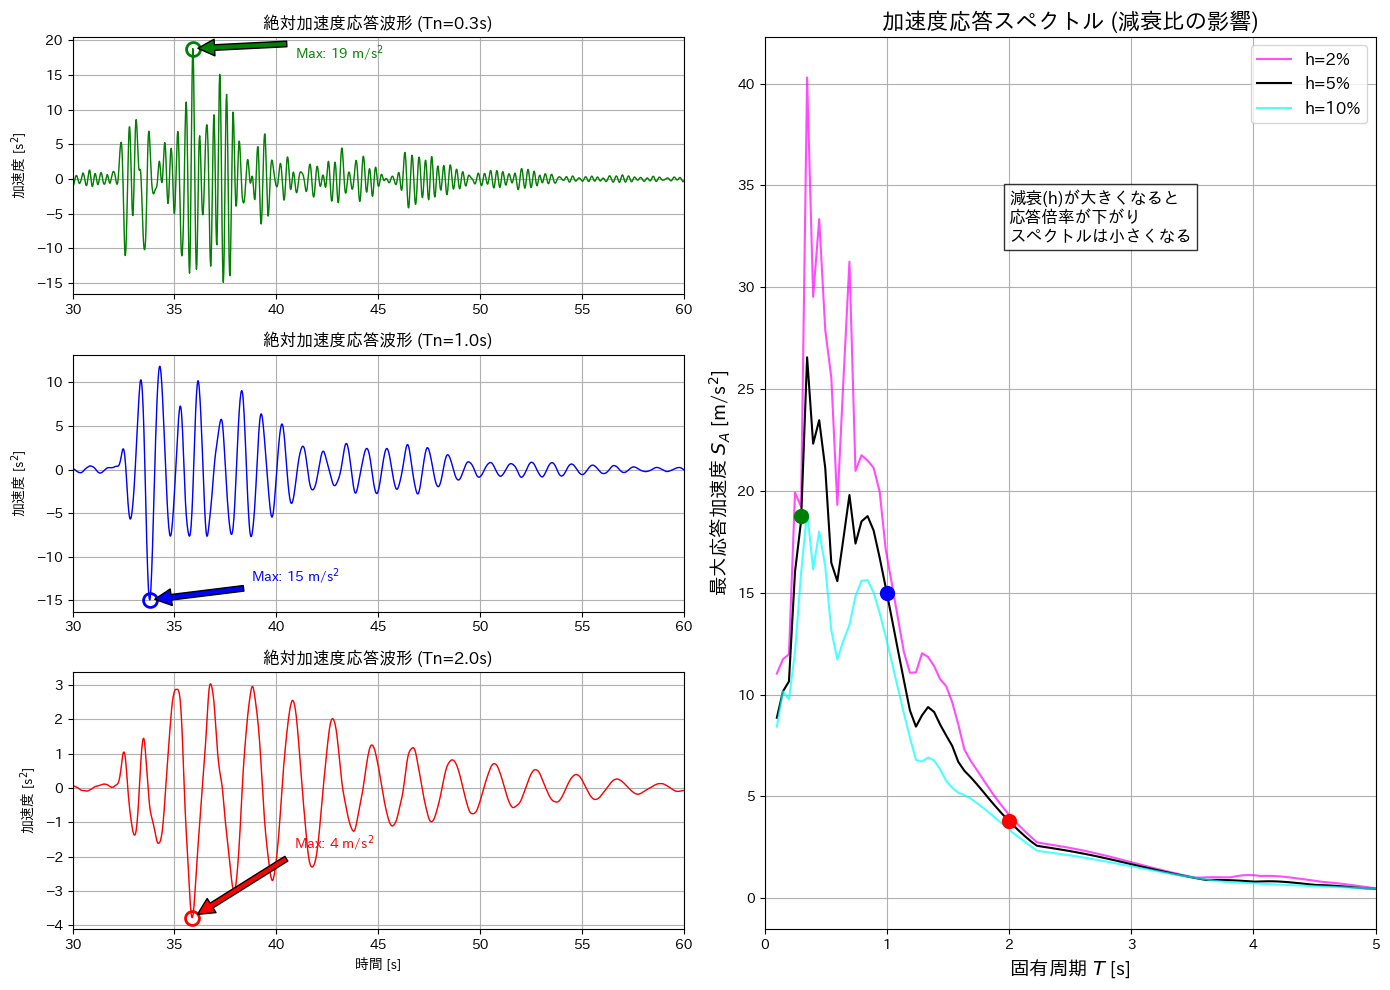

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

# -----------------------------------------------------------------
# 1. 地震波データの読み込み関数 (変更なし)
# -----------------------------------------------------------------
def load_jma_kobe_data(filename="1995兵庫県南部地震.csv", component='NS'):
    with open(filename, 'r', encoding='shift_jis') as f:
        for i, line in enumerate(f):
            if i == 3:  # 4行目 (SAMPLING RATE)
                rate_str = line.split(',')[0].split('=')[1]
                dt = 1.0 / float(rate_str.replace('Hz', '').strip())
                break
    data = pd.read_csv(
        filename,
        skiprows=7,
        header=None,
        usecols=[0, 1, 2],
        names=['NS', 'EW', 'UD'],
        encoding='shift_jis'
    )
    data = data.fillna(0)
    ag = data[component].to_numpy(dtype=float)/100
    return ag, dt

# -----------------------------------------------------------------
# 2. Newmark-β法 汎用ソルバー (変更なし)
# -----------------------------------------------------------------
def newmark_beta(m, c, k, p_force, dt, u0, v0, beta, gamma):
    n_steps = len(p_force)
    u = np.zeros(n_steps)
    v = np.zeros(n_steps)
    a = np.zeros(n_steps)

    u[0] = u0
    v[0] = v0
    a[0] = (p_force[0] - c * v[0] - k * u[0]) / m

    a0 = 1.0 / (beta * dt**2)
    a1 = gamma / (beta * dt)
    a2 = 1.0 / (beta * dt)
    a3 = 1.0 / (2.0 * beta) - 1.0
    a4 = gamma / beta - 1.0
    a5 = (dt / 2.0) * (gamma / beta - 2.0)
    a6 = dt * (1.0 - gamma)
    a7 = gamma * dt

    K_hat = k + a0 * m + a1 * c

    for i in range(n_steps - 1):
        P_hat = p_force[i+1] + m * (a0*u[i] + a2*v[i] + a3*a[i]) \
                               + c * (a1*u[i] + a4*v[i] + a5*a[i])

        u[i+1] = P_hat / K_hat
        a[i+1] = a0 * (u[i+1] - u[i]) - a2 * v[i] - a3 * a[i]
        v[i+1] = v[i] + a6 * a[i] + a7 * a[i+1]

    t = np.arange(0, n_steps * dt, dt)
    return t, u, v, a

# -----------------------------------------------------------------
# 3. メイン実行部
# -----------------------------------------------------------------
if __name__ == "__main__":

    # --- (A) データの準備 ---
    try:
        ag, dt = load_jma_kobe_data(filename="1995兵庫県南部地震.csv", component='NS')
    except Exception as e:
        print(f"Error: {e}")
        exit()

    # --- (B) 解析パラメータ ---
    m = 1.0
    beta, gamma = 1/4, 1/2

    h_list = [0.02, 0.05, 0.10]
    T_list = np.linspace(0.1, 5.0, 100)

    spectrum_data = {'Period_T': T_list}

    print("解析を開始します...")

    # --- (C.1) 各減衰比について応答スペクトルを計算 ---
    for h in h_list:
        print(f" 1. 応答スペクトル計算中 (h={h*100:.0f}%)...")
        max_acc_response = []

        for Tn in T_list:
            wn = 2.0 * np.pi / Tn
            k = wn**2 * m
            c = 2.0 * h * wn * m
            p_force = -m * ag

            t, u, v, a = newmark_beta(m, c, k, p_force, dt, 0, 0, beta, gamma)

            a_abs = ag + a
            max_val = np.max(np.abs(a_abs))
            max_acc_response.append(max_val)

        spectrum_data[f'Sa_h{h}'] = max_acc_response

    output_csv = "response_spectrum_combined.csv"
    pd.DataFrame(spectrum_data).to_csv(output_csv, index=False)
    print(f"全スペクトルデータを {output_csv} に保存しました。")

    # --- (C.2) デモ用波形（グラフ左側）の計算 (h=0.05) ---
    print(" 2. デモ用波形を計算中 (h=0.05)...")
    demo_Ts = [0.3, 1.0, 2.0]
    demo_colors = ['green', 'blue', 'red']
    demo_waveforms = {}
    h_demo = 0.05

    for target_T in demo_Ts:
        wn = 2.0 * np.pi / target_T
        k = wn**2 * m
        c = 2.0 * h_demo * wn * m
        p_force = -m * ag

        t, u, v, a = newmark_beta(m, c, k, p_force, dt, 0, 0, beta, gamma)

        a_abs = ag + a

        # ★★★ 修正点 1：絶対値の最大値を持つインデックスを探す ★★★
        idx_max = np.argmax(np.abs(a_abs))

        # そのインデックスの「符号付きの値」と「絶対値」の両方を取得
        val_peak_signed = a_abs[idx_max]  # 実際にプロットするY座標 (例: -850)
        val_peak_abs = np.abs(val_peak_signed) # 表示する文字 (例: 850)
        time_peak = t[idx_max]            # X座標

        demo_waveforms[target_T] = {
            't': t,
            'a_abs': a_abs,
            'val_peak_signed': val_peak_signed, # 符号付き
            'val_peak_abs': val_peak_abs,       # 絶対値
            'max_time': time_peak
        }

    # --- (D) グラフ描画 ---
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(3, 2)
    ax_waves = [fig.add_subplot(gs[i, 0]) for i in range(3)]
    ax_spec = fig.add_subplot(gs[:, 1])

    # 1. 左側：時系列波形
    for i, target_T in enumerate(demo_Ts):
        data = demo_waveforms[target_T]
        color = demo_colors[i]
        ax = ax_waves[i]

        ax.plot(data['t'], data['a_abs'], color='gray', linewidth=0.5, alpha=0.5)
        ax.plot(data['t'], data['a_abs'], color=color, linewidth=1.0, label=f'Tn={target_T}s (h=0.05)')

        # ★★★ 修正点 2：符号付きのピーク位置に○を描画 ★★★
        # (前回はプラスとマイナス両方に描いていましたが、今回は実際のピーク1点のみにします)
        ax.plot(data['max_time'], data['val_peak_signed'], 'o', color=color, markersize=10, markerfacecolor='none', markeredgewidth=2)

        ax.set_title(f'絶対加速度応答波形 (Tn={target_T}s)', fontsize=12)
        ax.set_ylabel('加速度 [s$^2$]')
        if i == 2: ax.set_xlabel('時間 [s]')
        ax.set_xlim(30, 60)
        ax.grid(True)

        # ★★★ 修正点 3：ピークの符号に応じて注釈の位置を変える ★★★
        if data['val_peak_signed'] >= 0:
            # 正（上側）にピークがある場合 -> 文字はさらに上に
            xytext_offset = (data['max_time'] + 5, data['val_peak_signed']- 1.50) #+ 1.50
        else:
            # 負（下側）にピークがある場合 -> 文字はさらに下に
            xytext_offset = (data['max_time'] + 5, data['val_peak_signed']+ 2.00) #- 2.00

        ax.annotate(f'Max: {data["val_peak_abs"]:.0f} m/s$^2$',
                    xy=(data['max_time'], data['val_peak_signed']),
                    xytext=xytext_offset,
                    arrowprops=dict(facecolor=color, shrink=0.05),
                    color=color, fontsize=10, fontweight='bold')

    # 2. 右側：応答スペクトル (前回と同じ)
    linestyles = ['dotted', 'solid', 'dashed']
    spec_colors = ['magenta', 'black', 'cyan']

    for i, h in enumerate(h_list):
        label_str = f'h={h*100:.0f}%'
        sa_data = spectrum_data[f'Sa_h{h}']
        lw = 1.5 if h == 0.05 else 1.5
        alpha = 1.0 if h == 0.05 else 0.7
        ax_spec.plot(T_list, sa_data, label=label_str,
                     color=spec_colors[i], linewidth=lw, alpha=alpha)

    # h=0.05 の時のデモ点（〇）をプロット
    for i, target_T in enumerate(demo_Ts):
        max_val = demo_waveforms[target_T]['val_peak_abs'] # スペクトルは絶対値
        color = demo_colors[i]
        ax_spec.plot(target_T, max_val, 'o', color=color, markersize=10, zorder=10)

    ax_spec.set_title('加速度応答スペクトル (減衰比の影響)', fontsize=16)
    ax_spec.set_xlabel('固有周期 $T$ [s]', fontsize=14)
    ax_spec.set_ylabel('最大応答加速度 $S_A$ [m/s$^2$]', fontsize=14)
    ax_spec.set_xlim(0, 5.0)
    ax_spec.grid(True, which="both", ls="-")
    ax_spec.legend(fontsize=12, loc='upper right')

    ax_spec.text(2.0, max(spectrum_data['Sa_h0.02'])*0.8,
                 '減衰(h)が大きくなると\n応答倍率が下がり\nスペクトルは小さくなる',
                 fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()